In [ ]:
!pip install transformers onnxruntime onnx datasets

In [ ]:
import sys
!{sys.executable} -m pip install --upgrade git+https://github.com/huggingface/transformers
!{sys.executable} -m pip install --upgrade torch==1.6.0+cpu torchvision==0.7.0+cpu -f https://download.pytorch.org/whl/torch_stable.html
!{sys.executable} -m pip install --upgrade onnxruntime==1.4.0
!{sys.executable} -m pip install -i https://test.pypi.org/simple/ ort-nightly
!{sys.executable} -m pip install --upgrade onnxruntime-tools

In [7]:
import torch
from torch import nn
import torch.nn.utils.prune as prune
import pandas as pd

from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
from evaluate import evaluator
import evaluate

In [10]:
data = load_dataset("imdb",
                    split="test").shuffle().select(range(1000))

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [11]:
task_evaluator = evaluator("text-classification")

In [13]:
tokenizer = AutoTokenizer.from_pretrained("lvwerra/distilbert-imdb")
model = AutoModelForSequenceClassification.from_pretrained("lvwerra/distilbert-imdb").eval()

#**Сonvert to ONNX**

In [15]:
!rm -rf onnx/
from pathlib import Path
from transformers.convert_graph_to_onnx import convert

# Handles all the above steps for you
convert(framework="pt", model="lvwerra/distilbert-imdb", output=Path("onnx/lvwerra-distilbert-imdb.onnx"), opset=11)

# Tensorflow
# convert(framework="tf", model="bert-base-cased", output="onnx/bert-base-cased.onnx", opset=11)

ONNX opset version set to: 11
Loading pipeline (model: lvwerra/distilbert-imdb, tokenizer: lvwerra/distilbert-imdb)
Creating folder onnx
Using framework PyTorch: 2.0.1+cu118
Found input input_ids with shape: {0: 'batch', 1: 'sequence'}
Found input attention_mask with shape: {0: 'batch', 1: 'sequence'}
Found output output_0 with shape: {0: 'batch', 1: 'sequence'}
Ensuring inputs are in correct order
head_mask is not present in the generated input list.
Generated inputs order: ['input_ids', 'attention_mask']


/usr/local/lib/python3.10/dist-packages/transformers/models/distilbert/modeling_distilbert.py:223: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  mask, torch.tensor(torch.finfo(scores.dtype).min)


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [16]:
from os import environ
from psutil import cpu_count

# Constants from the performance optimization available in onnxruntime
# It needs to be done before importing onnxruntime
environ["OMP_NUM_THREADS"] = str(cpu_count(logical=True))
environ["OMP_WAIT_POLICY"] = 'ACTIVE'

from onnxruntime import GraphOptimizationLevel, InferenceSession, SessionOptions, get_all_providers

In [17]:
from contextlib import contextmanager
from dataclasses import dataclass
from time import time
from tqdm import trange

def create_model_for_provider(model_path: str, provider: str) -> InferenceSession:

  assert provider in get_all_providers(), f"provider {provider} not found, {get_all_providers()}"

  # Few properties that might have an impact on performances (provided by MS)
  options = SessionOptions()
  options.intra_op_num_threads = 1
  options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL

  # Load the model as a graph and prepare the CPU backend
  session = InferenceSession(model_path, options, providers=[provider])
  session.disable_fallback()

  return session


@contextmanager
def track_infer_time(buffer: [int]):
    start = time()
    yield
    end = time()

    buffer.append(end - start)


@dataclass
class OnnxInferenceResult:
  model_inference_time: [int]
  optimized_model_path: str

In [22]:
cpu_model = create_model_for_provider("onnx/lvwerra-distilbert-imdb.onnx", "CPUExecutionProvider")

# Inputs are provided through numpy array
model_inputs = tokenizer("My name is Bert", return_tensors="pt")
inputs_onnx = {k: v.cpu().detach().numpy() for k, v in model_inputs.items()}

# Benchmarking PyTorch model CPU_

In [20]:
from transformers import BertModel

PROVIDERS = {
    ("cpu", "PyTorch CPU"),
#  Uncomment this line to enable GPU benchmarking
#    ("cuda:0", "PyTorch GPU")
}

results = {}

for device, label in PROVIDERS:

    # Move inputs to the correct device
    model_inputs_on_device = {
        arg_name: tensor.to(device)
        for arg_name, tensor in model_inputs.items()
    }

    # Add PyTorch to the providers
    model_pt = BertModel.from_pretrained("lvwerra/distilbert-imdb").to(device)
    for _ in trange(10, desc="Warming up"):
      model_pt(**model_inputs_on_device)

    # Compute
    time_buffer = []
    for _ in trange(100, desc=f"Tracking inference time on PyTorch"):
      with track_infer_time(time_buffer):
        model_pt(**model_inputs_on_device)

    # Store the result
    results[label] = OnnxInferenceResult(
        time_buffer,
        None
    )

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertModel were not initialized from the model checkpoint at lvwerra/distilbert-imdb and are newly initialized: ['encoder.layer.4.output.LayerNorm.bias', 'encoder.layer.11.attention.output.LayerNorm.weight', 'encoder.layer.7.attention.output.dense.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.9.output.dense.weight', 'encoder.layer.6.attention.output.LayerNorm.bias', 'encoder.layer.9.attention.self.value.bias', 'encoder.layer.8.attention.self.value.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.11.output.LayerNorm.bias', 'encoder.layer.1.attention.output.LayerNorm.weight', 'encoder.layer.2.output.LayerNorm.weight', 'encoder.layer.5.attention.output.LayerNorm.bias', 'encoder.layer.10.attention.self.value.bias', 'encoder.layer.4.output.L

## Benchmarking PyTorch & ONNX on CPU

In [21]:
PROVIDERS = {
    ("CPUExecutionProvider", "ONNX CPU"),
#  Uncomment this line to enable GPU benchmarking
#     ("CUDAExecutionProvider", "ONNX GPU")
}


for provider, label in PROVIDERS:
    # Create the model with the specified provider
    model = create_model_for_provider("onnx/lvwerra-distilbert-imdb.onnx", provider)

    # Keep track of the inference time
    time_buffer = []

    # Warm up the model
    model.run(None, inputs_onnx)

    # Compute
    for _ in trange(100, desc=f"Tracking inference time on {provider}"):
      with track_infer_time(time_buffer):
          model.run(None, inputs_onnx)

    # Store the result
    results[label] = OnnxInferenceResult(
      time_buffer,
      model.get_session_options().optimized_model_filepath
    )

Tracking inference time on CPUExecutionProvider: 100%|██████████| 100/100 [00:01<00:00, 50.04it/s]


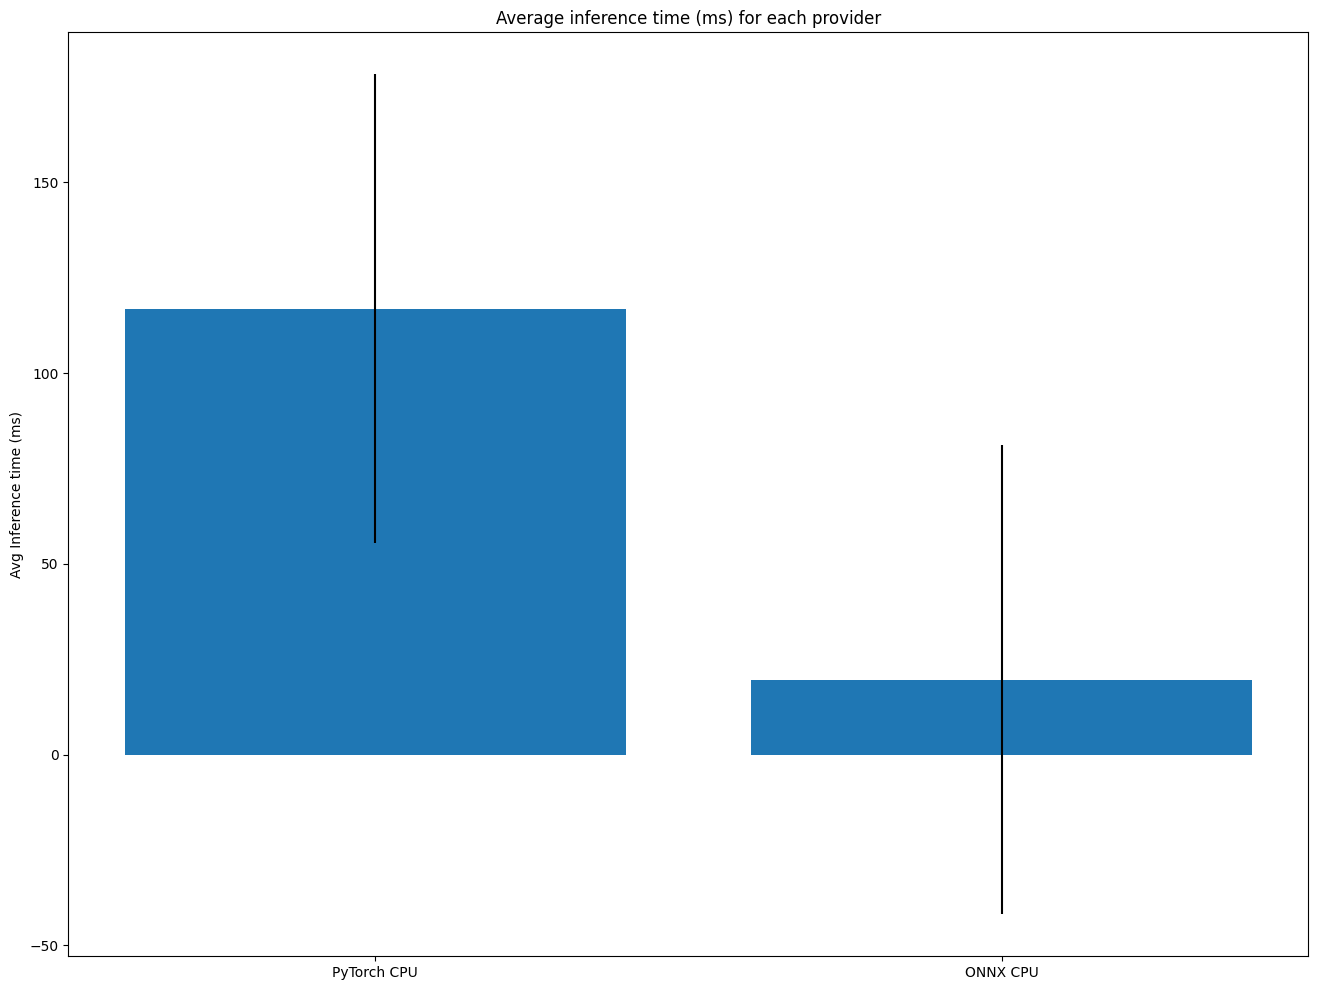

In [23]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os


# Compute average inference time + std
time_results = {k: np.mean(v.model_inference_time) * 1e3 for k, v in results.items()}
time_results_std = np.std([v.model_inference_time for v in results.values()]) * 1000

plt.rcdefaults()
fig, ax = plt.subplots(figsize=(16, 12))
ax.set_ylabel("Avg Inference time (ms)")
ax.set_title("Average inference time (ms) for each provider")
ax.bar(time_results.keys(), time_results.values(), yerr=time_results_std)
plt.show()